In [1]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation, Input
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./Data/WISDM.csv", index_col=0)
df

,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [3]:
df.isna().sum()

user-id      0
activity     0
timestamp    0
X            0
Y            0
Z            0
dtype: int64

In [4]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

In [5]:
df.rename(columns={'activity': 'label'}, inplace=True)
df

,user-id,label,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [6]:
df

,user-id,label,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   label      1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   X          1098203 non-null  float64
 4   Y          1098203 non-null  float64
 5   Z          1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [8]:
df_sitting = df[df['label'] == 'Jogging'].sample(n=4500, random_state=42)
df_jogging = df[df['label'] == 'Sitting'].sample(n=4500, random_state=42)
len(df_sitting), len(df_jogging)

(4500, 4500)

In [9]:
df_train = pd.concat([df_sitting, df_jogging], axis=0)
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,Jogging,0,0.00,0.00,0.000000
164275,6,Jogging,2694792247000,-0.46,-0.46,1.334794
813141,31,Jogging,23960721626000,19.08,18.35,2.910000
1002308,2,Jogging,9022662336000,3.06,-0.30,1.920000
815984,31,Jogging,24102851723000,-0.23,4.25,-4.710000
...,...,...,...,...,...,...
503398,32,Sitting,2480612315000,7.74,-1.95,4.560000
1051607,7,Sitting,209336691499000,-6.47,-3.26,6.850000
398029,5,Sitting,3079682232000,4.33,3.06,8.008764
570806,20,Sitting,58707702282000,0.00,4.21,9.110000


In [10]:
df_train['label'] = df_train['label'].replace({'Sitting': 0, 'Jogging': 1})
df_train

,user-id,label,timestamp,X,Y,Z
110810,13,1,0,0.00,0.00,0.000000
164275,6,1,2694792247000,-0.46,-0.46,1.334794
813141,31,1,23960721626000,19.08,18.35,2.910000
1002308,2,1,9022662336000,3.06,-0.30,1.920000
815984,31,1,24102851723000,-0.23,4.25,-4.710000
...,...,...,...,...,...,...
503398,32,0,2480612315000,7.74,-1.95,4.560000
1051607,7,0,209336691499000,-6.47,-3.26,6.850000
398029,5,0,3079682232000,4.33,3.06,8.008764
570806,20,0,58707702282000,0.00,4.21,9.110000


In [11]:
X_train, X_test = train_test_split(df_train, test_size=0.25, random_state=42)

In [12]:
X_train.shape, X_test.shape

((6750, 6), (2250, 6))

In [13]:
X_train

,user-id,label,timestamp,X,Y,Z
892675,3,0,102454691688000,1.73,0.31,9.620000
734136,34,1,1669032329000,6.51,8.54,-7.010000
640918,12,0,18710382027000,8.16,-1.99,3.980000
816517,31,1,24129523292000,5.56,-6.13,-1.310000
1019400,2,1,10255572339000,-19.61,1.65,-0.760000
...,...,...,...,...,...,...
459991,18,0,308662334000,5.56,1.73,8.430000
253579,36,0,14841892255000,-4.86,-2.22,7.886181
469719,16,0,1037842326000,5.56,2.56,8.160000
889812,3,1,102164821601000,3.06,12.98,3.680000


In [14]:
X_test

,user-id,label,timestamp,X,Y,Z
221443,27,0,12369512281000,3.26,9.28,1.334794
320648,35,1,571192241000,-5.75,8.28,4.058864
635169,12,1,18211209084000,0.15,13.06,-4.400000
842769,21,1,117594861548000,4.21,7.82,4.940000
1052526,7,0,209382641511000,-6.82,-3.41,6.700000
...,...,...,...,...,...,...
580550,20,0,59194892346000,-4.14,3.02,8.580000
320906,35,1,584062205000,-7.63,9.66,5.175732
608732,24,1,15367212229000,-1.95,-4.21,7.040000
999724,2,1,8893492322000,12.45,-3.68,10.760000


In [15]:
sitting = X_train[X_train['label'] == 0]

y_train = sitting['label']

X_train_sitting_train = sitting.drop(['label'], axis=1)

y_test = X_test['label']

X_test = X_test.drop(['label'], axis=1)
X_train_sitting_train.shape, X_test.shape

((3368, 5), (2250, 5))

In [16]:
features = ['X', 'Y', 'Z']

# 피쳐 선택
X_train_sitting = X_train_sitting_train[features]
X_test = X_test[features]
X_train_sitting

,X,Y,Z
892675,1.73,0.31,9.620000
640918,8.16,-1.99,3.980000
576284,-1.53,3.64,9.430000
1095958,8.96,-0.76,2.300000
573896,-0.99,3.72,9.470000
...,...,...,...
829166,0.84,-0.15,9.700000
459991,5.56,1.73,8.430000
253579,-4.86,-2.22,7.886181
469719,5.56,2.56,8.160000


In [17]:
X_test

,X,Y,Z
221443,3.26,9.28,1.334794
320648,-5.75,8.28,4.058864
635169,0.15,13.06,-4.400000
842769,4.21,7.82,4.940000
1052526,-6.82,-3.41,6.700000
...,...,...,...
580550,-4.14,3.02,8.580000
320906,-7.63,9.66,5.175732
608732,-1.95,-4.21,7.040000
999724,12.45,-3.68,10.760000


In [18]:
# 표준화
scaler = StandardScaler()
X_train_sitting = scaler.fit_transform(X_train_sitting)
X_test = scaler.fit_transform(X_test)
X_train_sitting

array([[-0.02134624, -0.45921221,  0.82566489],
       [ 1.31267736, -1.17109903, -0.70441523],
       [-0.69769412,  0.5714761 ,  0.77411964],
       ...,
       [-1.38856482, -1.24228772,  0.35529585],
       [ 0.7732588 ,  0.23719881,  0.42958032],
       [ 1.46205481, -0.80277498, -1.16018378]])

In [19]:
# ====== 2) 오토 인코더 모델 학습 및 예측 ======
X_train_AE = X_train_sitting.copy()
X_test_AE = X_test.copy()
X_train_AE.shape

(3368, 3)

In [20]:
X_test.shape

(2250, 3)

In [21]:
# 파라미터 설정
n_input = X_train_AE.shape[1]
n_output = n_input
# 모델 레이어 설정
x_Input = Input(batch_shape=(None, n_input))
x_Encoder1 = Dense(256, activation='relu')(x_Input)
x_Encoder1 = Dropout(0.3)(x_Encoder1)
x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
x_Encoder2 = Dropout(0.2)(x_Encoder2)
y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
y_Decoder1 = Dropout(0.3)(y_Decoder1)
y_Decoder2 = Dense(n_output, activation='linear')(y_Decoder1)

In [22]:
# 모델 구조 설정
model = Model(x_Input, y_Decoder2)
model.compile(loss='mse', optimizer=Adam(lr=0.001))
print("====== 모델 전체 구조 ======")
print(model.summary())

# 모델 파라미터 및 조기 종료 조건
EPOCHS = int(input('학습 횟수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))
es = EarlyStopping(monitor='loss', patience=5, verbose=1)

====== 모델 전체 구조 ======
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 25

In [23]:
# 모델 훈련
hist = model.fit(X_train_AE, X_train_AE, 
                 epochs=EPOCHS,
                 batch_size=BATCH,
                 callbacks=[es],
                 shuffle=True)

Epoch 1/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0746
Epoch 2/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0422
Epoch 3/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0359
Epoch 4/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0331
Epoch 5/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0329
Epoch 6/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0257
Epoch 7/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0262
Epoch 8/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0277
Epoch 9/20
211/211 [==============================] - 1s 3ms/step - loss: 0.0257
Epoch 10/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0255
Epoch 11/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0284
Epoch 12/20
211/211 [==============================] - 1s 2ms/step - loss: 0.0234
Epoch 13/20
211/211 [====

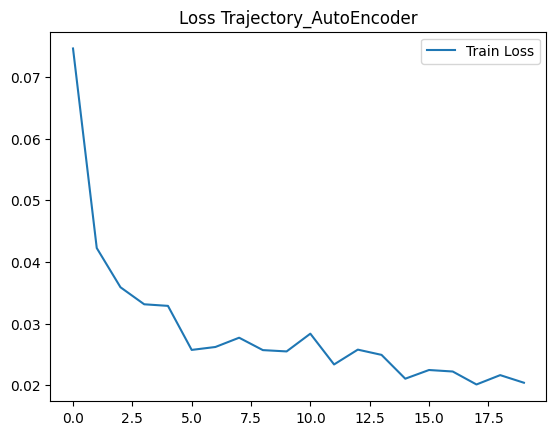

In [24]:
# loss 그래프
plt.plot(hist.history['loss'], label='Train Loss')
plt.title('Loss Trajectory_AutoEncoder')
plt.legend()
plt.show()

In [31]:
predictions = model.predict(X_test_AE)
predictions

71/71 [==============================] - 0s 1ms/step


array([[ 0.20950024,  0.20802525, -0.07796751],
       [-1.045718  ,  0.7102416 ,  0.10366502],
       [-0.21640798,  1.3083566 , -1.2486432 ],
       ...,
       [-0.53438395, -1.1173506 ,  0.7722701 ],
       [ 0.66673887, -0.3206793 ,  0.66660845],
       [-1.0605685 , -0.6704304 , -1.5540085 ]], dtype=float32)

In [32]:
mse = np.mean(np.power(X_test_AE - predictions, 2), axis=1)
mse


array([0.13365982, 0.0050045 , 0.00400865, ..., 0.01069996, 0.6044945 ,
       0.00899389])

In [26]:
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,2250.000000,2250.000000
mean,0.075931,0.496889
std,0.136552,0.500101
min,0.000089,0.000000
25%,0.008367,0.000000
50%,0.019606,0.000000
75%,0.082390,1.000000
max,1.292461,1.000000


In [27]:
error_df['true_class'].value_counts()

0    1132
1    1118
Name: true_class, dtype: int64

In [28]:
threshold = 0.07

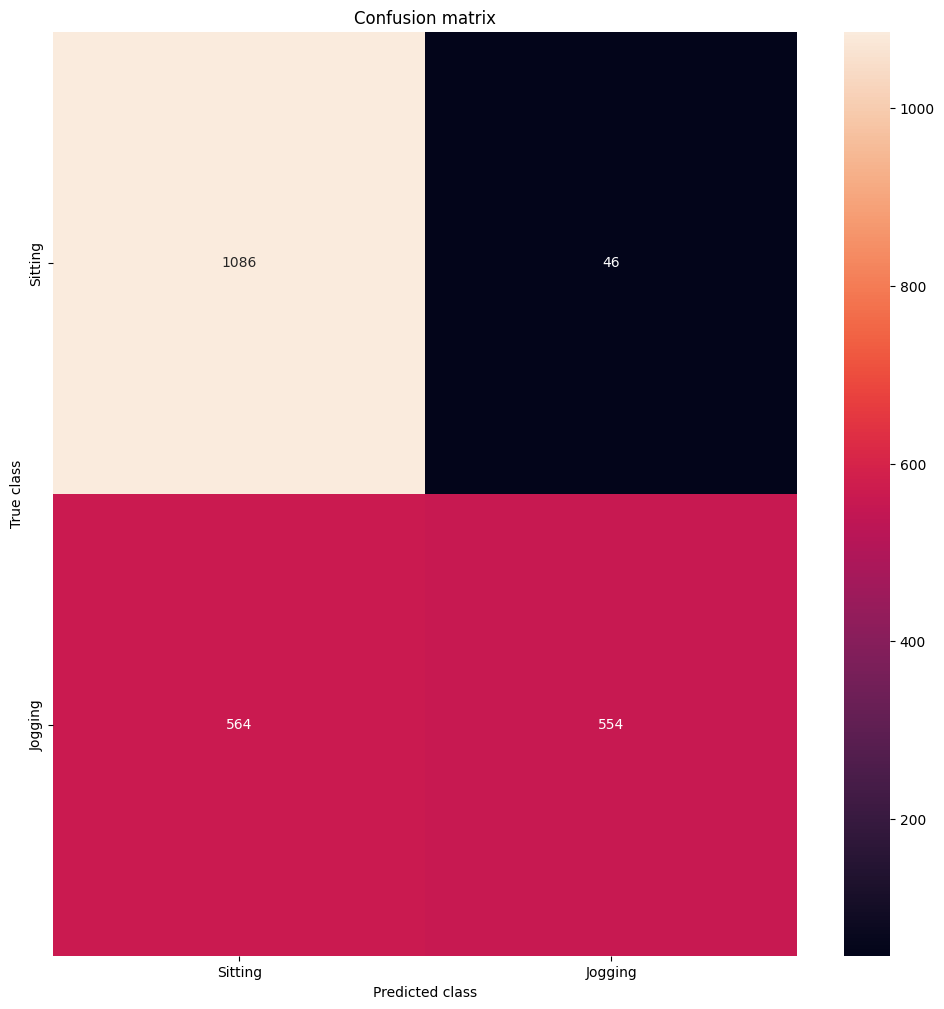

In [29]:
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

LABELS = ["Sitting", "Jogging"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


In [30]:
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )

print ('Precision :',precision )

print ('Recall :',recall )

print ('F1 :',f1 )

Accuracy Score : 0.7288888888888889
Precision : 0.9233333333333333
Recall : 0.49552772808586765
F1 : 0.6449359720605355
